In [4]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image


In [5]:
# Function to load and preprocess a single image
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img_array


In [6]:
# Directories
train_dir = 'Downloads/archive/train'
valid_dir = 'Downloads/archive/valid'
test_dir = 'Downloads/archive/test'

# Image Data Generator for Training, Validation, and Test sets
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    horizontal_flip=True,
    zoom_range=0.3,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    rotation_range=50,
    fill_mode='nearest'
)

valid_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)


Found 5959 images belonging to 8 classes.
Found 940 images belonging to 8 classes.
Found 940 images belonging to 8 classes.


In [7]:
# Load the ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))


In [8]:
# Freeze the initial layers of ResNet50
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)


In [9]:
# Create the model
model = Model(inputs=base_model.input, outputs=predictions)


In [10]:

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])


In [11]:

# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss', mode='min')


In [12]:
# Determine steps per epoch
steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = valid_generator.samples // valid_generator.batch_size


In [13]:
# Ensure the generators repeat indefinitely
train_dataset = tf.data.Dataset.from_generator(
    lambda: iter(train_generator),
    output_signature=(
        tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None, train_generator.num_classes), dtype=tf.float32))
).repeat()

valid_dataset = tf.data.Dataset.from_generator(
    lambda: iter(valid_generator),
    output_signature=(
        tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None, valid_generator.num_classes), dtype=tf.float32))
).repeat()


In [13]:
# Train the model
history = model.fit(
    train_dataset,
    steps_per_epoch=steps_per_epoch,
    validation_data=valid_dataset,
    validation_steps=validation_steps,
    epochs=20,
    callbacks=[reduce_lr, early_stopping, model_checkpoint]
)


Epoch 1/20
186/186 ━━━━━━━━━━━━━━━━━━━━ 417s 2s/step - accuracy: 0.6344 - loss: 20.7785 - val_accuracy: 0.9935 - val_loss: 16.9610 - learning_rate: 1.0000e-04
Epoch 2/20
186/186 ━━━━━━━━━━━━━━━━━━━━ 405s 2s/step - accuracy: 0.9600 - loss: 16.1164 - val_accuracy: 0.9956 - val_loss: 13.2406 - learning_rate: 1.0000e-04
Epoch 3/20
186/186 ━━━━━━━━━━━━━━━━━━━━ 404s 2s/step - accuracy: 0.9711 - loss: 12.5001 - val_accuracy: 0.9978 - val_loss: 10.1054 - learning_rate: 1.0000e-04
Epoch 4/20
186/186 ━━━━━━━━━━━━━━━━━━━━ 404s 2s/step - accuracy: 0.9712 - loss: 9.5258 - val_accuracy: 0.9967 - val_loss: 7.6394 - learning_rate: 1.0000e-04
Epoch 5/20
186/186 ━━━━━━━━━━━━━━━━━━━━ 405s 2s/step - accuracy: 0.9801 - loss: 7.1813 - val_accuracy: 0.9978 - val_loss: 5.7346 - learning_rate: 1.0000e-04
Epoch 6/20
186/186 ━━━━━━━━━━━━━━━━━━━━ 406s 2s/step - accuracy: 0.9785 - loss: 5.4054 - val_accuracy: 0.9956 - val_loss: 4.3039 - learning_rate: 1.0000e-04
Epoch 7/20
186/186 ━━━━━━━━━━━━━━━━━━━━ 403s 2s/step

In [14]:

# Save the model
model.save('myfinal4.h5')


In [15]:
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
print(f'Test accuracy: {test_accuracy * 100:.2f}%')


/opt/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


29/29 ━━━━━━━━━━━━━━━━━━━━ 27s 909ms/step - accuracy: 0.9980 - loss: 0.1904
Test accuracy: 99.78%


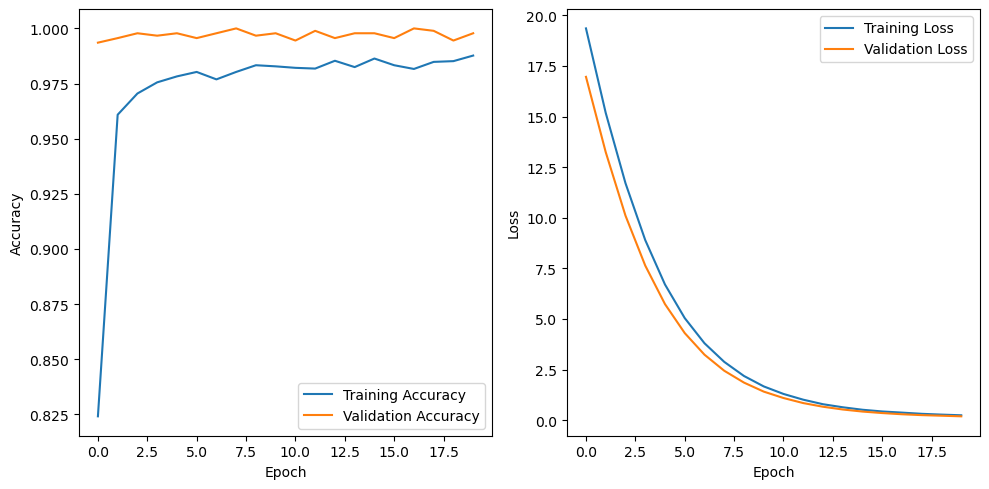

In [16]:
# Plotting the training history
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [17]:
# Fine-tuning the model
# Unfreeze some layers of the base model
for layer in base_model.layers[-10:]:
    layer.trainable = True

In [18]:
# Recompile the model with a very low learning rate
model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])


In [19]:
# Continue training the model
fine_tune_epochs = 10
total_epochs = 20 + fine_tune_epochs

fine_tune_history = model.fit(
    train_dataset,
    steps_per_epoch=steps_per_epoch,
    validation_data=valid_dataset,
    validation_steps=validation_steps,
    epochs=total_epochs,
    initial_epoch=20,
    callbacks=[reduce_lr, early_stopping, model_checkpoint]
)


Epoch 21/30
186/186 ━━━━━━━━━━━━━━━━━━━━ 234s 1s/step - accuracy: 0.9864 - loss: 0.2216 - val_accuracy: 0.9945 - val_loss: 0.1812 - learning_rate: 1.0000e-05
Epoch 22/30
186/186 ━━━━━━━━━━━━━━━━━━━━ 228s 1s/step - accuracy: 0.9909 - loss: 0.2064 - val_accuracy: 0.9989 - val_loss: 0.1701 - learning_rate: 1.0000e-05
Epoch 23/30
186/186 ━━━━━━━━━━━━━━━━━━━━ 229s 1s/step - accuracy: 0.9909 - loss: 0.1967 - val_accuracy: 0.9978 - val_loss: 0.1667 - learning_rate: 1.0000e-05
Epoch 24/30
186/186 ━━━━━━━━━━━━━━━━━━━━ 230s 1s/step - accuracy: 0.9923 - loss: 0.1882 - val_accuracy: 0.9967 - val_loss: 0.1614 - learning_rate: 1.0000e-05
Epoch 25/30
186/186 ━━━━━━━━━━━━━━━━━━━━ 231s 1s/step - accuracy: 0.9938 - loss: 0.1775 - val_accuracy: 0.9967 - val_loss: 0.1535 - learning_rate: 1.0000e-05
Epoch 26/30
186/186 ━━━━━━━━━━━━━━━━━━━━ 236s 1s/step - accuracy: 0.9927 - loss: 0.1722 - val_accuracy: 0.9978 - val_loss: 0.1480 - learning_rate: 1.0000e-05
Epoch 27/30
186/186 ━━━━━━━━━━━━━━━━━━━━ 348s 2s/ste

In [20]:
# Save the model
model.save('myfinal4afterfinetune.h5')

In [21]:
# Evaluate the fine-tuned model
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
print(f'Fine-tuned test accuracy: {test_accuracy * 100:.2f}%')


29/29 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - accuracy: 0.9981 - loss: 0.1274
Fine-tuned test accuracy: 99.78%


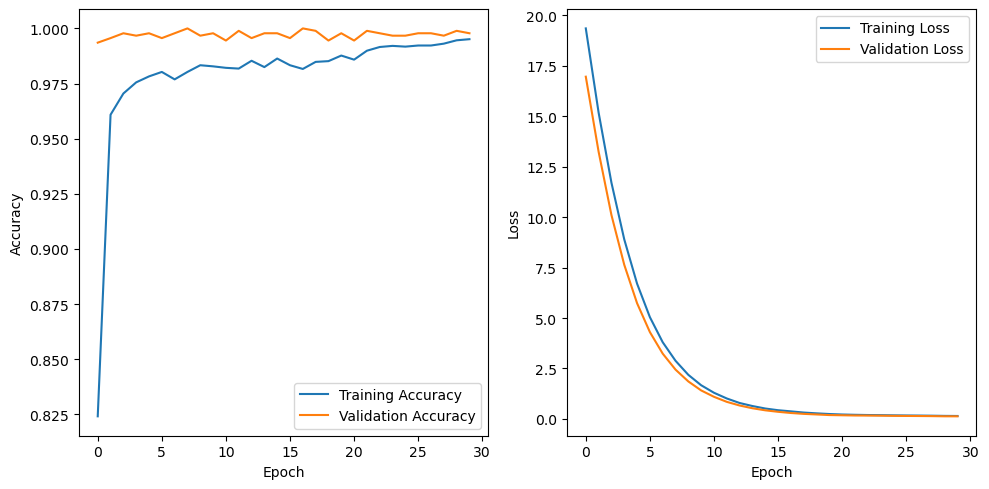

In [22]:
# Plotting the fine-tuning training history
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'] + fine_tune_history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'] + fine_tune_history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'] + fine_tune_history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'] + fine_tune_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()



1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 918ms/step
Predicted class: motorbike with confidence: 1.00


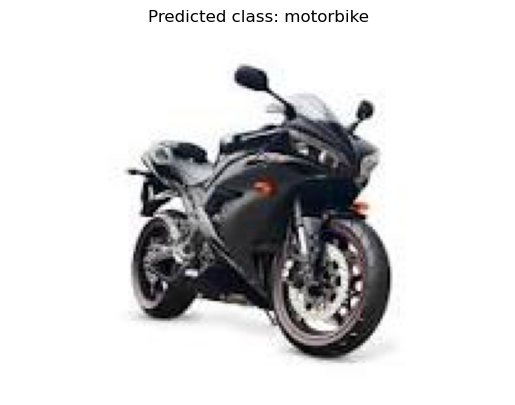

In [23]:
# Predicting and handling unknown classes
confidence_threshold = 0.7  # Set a threshold for confidence

def predict_image(image_path):
    img = preprocess_image(image_path)
    predictions = model.predict(img)
    confidence = np.max(predictions)
    predicted_class = np.argmax(predictions, axis=1)

    if confidence < confidence_threshold:
        return "unknown", confidence

    class_labels = list(train_generator.class_indices.keys())
    predicted_class_name = class_labels[predicted_class[0]]
    return predicted_class_name, confidence

example_image_path = 'Downloads/download.jpeg'
predicted_class_name, confidence = predict_image(example_image_path)
print(f'Predicted class: {predicted_class_name} with confidence: {confidence:.2f}')

# Show the image with the predicted class
img = Image.open(example_image_path)
plt.imshow(img)
plt.title(f'Predicted class: {predicted_class_name}')
plt.axis('off')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


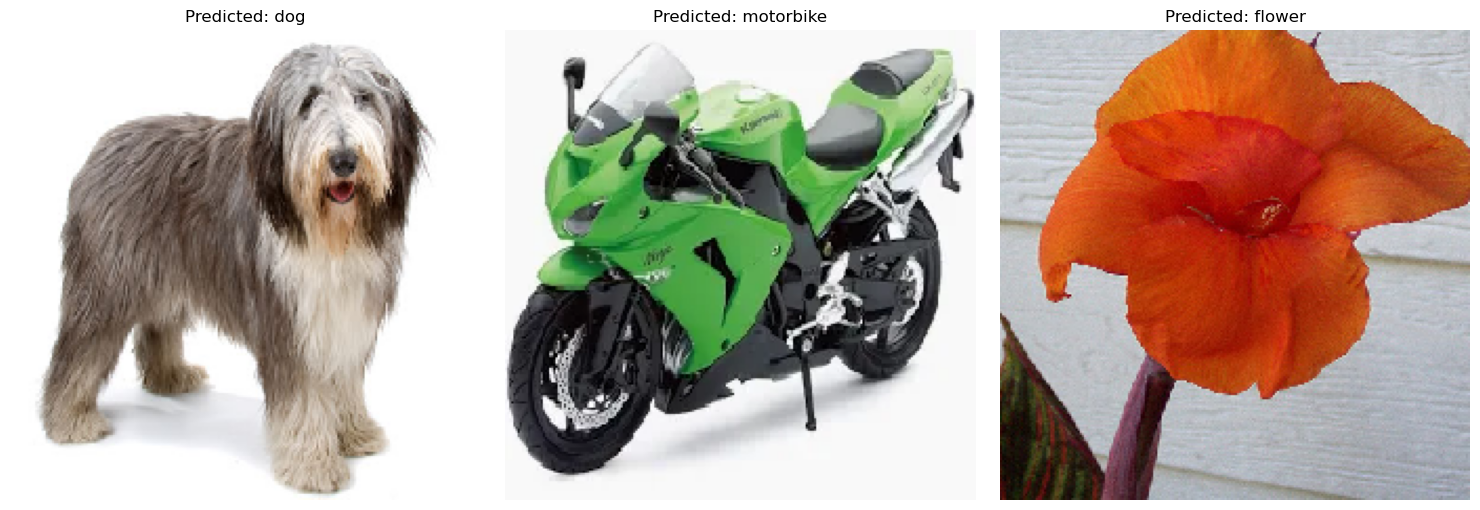

Image: Downloads/Bearded_collie_01231 copy.jpg, Predicted class: dog
Image: Downloads/motorbike.webp, Predicted class: motorbike
Image: Downloads/flower.jpg, Predicted class: flower


In [36]:
# Function to preprocess multiple images
def preprocess_images(image_paths):
    images = []
    for image_path in image_paths:
        img_array = preprocess_image(image_path)
        images.append(img_array)
    return np.vstack(images)
# Example image paths
example_image_paths = ['Downloads/Bearded_collie_01231 copy.jpg', 'Downloads/motorbike.webp','Downloads/flower.jpg']

# Preprocess the updated images
example_images = preprocess_images(example_image_paths)

# Make predictions
predictions = model.predict(example_images)
confidences = np.max(predictions, axis=1)
predicted_classes = np.argmax(predictions, axis=1)

# Map class indices to class names
class_labels = list(train_generator.class_indices.keys())
predicted_class_names = ["unknown" if conf < confidence_threshold else class_labels[pred] for conf, pred in zip(confidences, predicted_classes)]

# Display images with predicted labels
plt.figure(figsize=(15, 5))  # Adjust figsize as needed

for i, image_path in enumerate(example_image_paths):
    img = load_img(image_path, target_size=(224, 224))
    plt.subplot(1, len(example_image_paths), i + 1)  # Adjust subplot parameters for new image
    plt.imshow(img)
    plt.title(f'Predicted: {predicted_class_names[i]}')
    plt.axis('off')

plt.tight_layout()
plt.show()

# Print predictions
for image_path, predicted_class_name in zip(example_image_paths, predicted_class_names):
    print(f'Image: {image_path}, Predicted class: {predicted_class_name}')
